## 로지스틱 회귀(Logistic Regression)
- 데이터 위주의 접근 방식이라기보다, 구조화된 모델의 접근 방식
- 빠른 계산 속도 및 새로운 데이터에 대한 빠른 점수 산정 덕분에 다양한 분야에서 널리 사용

## 용어
- 로짓(logit): (0~1이 아니라)±∞의 범위에서 어떤 클래스에 속할 확률을 결정하는 함수(유의어: 로그 오즈)
- 오즈(odds): '실패(0)'에 대한 '성공(1)'의 비율
- 로그 오즈(log odds): 변환 모델(선형)의 응답변수. 이 값을 통해 확률을 구한다.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

## 로짓(logit)

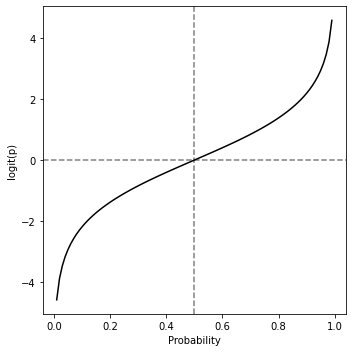

In [2]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'], color='black')
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()

## 로지스틱 회귀와 GLM
- 회귀방정식에 응답변수는 ±∞의 범위 로짓(로그 오즈 값)이지만 실제 관찰한 데이터는 로짓이 아닌 이진 출력값
- 이 회귀방정식을 위해서는 특별한 확률 기법이 필요
- 로지스틱 회귀는 선형회귀를 확장한 일반화선형모형(GLM)의 특별한 사례

In [3]:
loan_data = pd.read_csv('../../data/loan_data.csv', index_col=0)

In [4]:
features = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 'borrower_score']
label = 'outcome'

X = pd.get_dummies(loan_data[features], prefix='', prefix_sep='', 
                   drop_first=True)
y = loan_data[label].replace({'paid off':0, 'default':1})

logit_reg = LogisticRegression(penalty='l2', # 정규화 방법
                               C=1e42,       # 정규화 강도(C값이 낮을수록 정규화가 강화, 정규화 없이 피팅하려면 매우 큰 값으로 설정)
                              solver='liblinear') 
logit_reg.fit(X, y)

coef_df = pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)
coef_df.loc['intercept'] = logit_reg.intercept_
coef_df

,coeff
payment_inc_ratio,0.079728
borrower_score,-4.611037
debt_consolidation,0.249342
home_improvement,0.407614
major_purchase,0.229376
medical,0.510087
other,0.620534
small_business,1.215662
OWN,0.048453
RENT,0.157355


### 로지스틱 회귀와 예측값(Predicted Values from Logistic Regression)

In [5]:
# 로그 오즈에 관한 통계량
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=['paid off', 'default'])
pred.describe()

,paid off,default
count,45342.000000,45342.000000
mean,-0.760423,-0.757850
std,0.390419,0.378032
min,-3.538865,-2.768873
25%,-0.977164,-0.985728
50%,-0.688946,-0.697366
75%,-0.467076,-0.472209
max,-0.064787,-0.029476


In [6]:
# 예측 확률에 대한 통계랑
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=['paid off', 'default'])
pred.describe()

,paid off,default
count,45342.000000,45342.000000
mean,0.499999,0.500001
std,0.167336,0.167336
min,0.029046,0.062733
25%,0.376377,0.373167
50%,0.502105,0.497895
75%,0.626833,0.623623
max,0.937267,0.970954


## 계수와 오즈비 해석

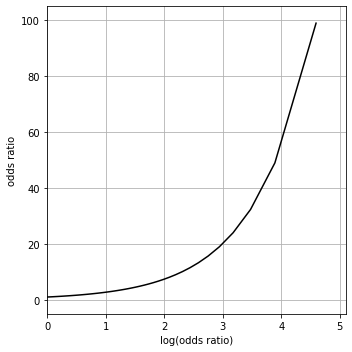

In [7]:
# 오즈비가 1보다 클경우, 오즈비와 로그 오즈비 사이의 관계
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(df['logit'], df['odds'], color='black')
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5, 105)
ax.grid()

plt.tight_layout()
plt.show()

## 잔차분석

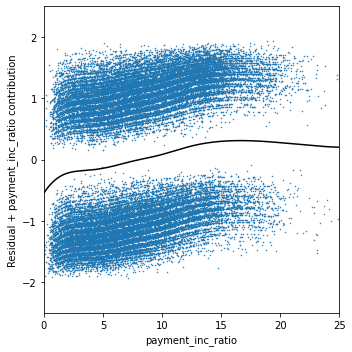

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.generalized_linear_model import GLMResults

formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()

def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)


plt.tight_layout()
plt.show()